In [1]:
from google.colab import drive
drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/DrugFinder-main')
!pip install fair-esm
!pip install Bio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import esm
from typing import Union
import torch
import torch.nn as nn

import esm
from esm.modules import ContactPredictionHead, ESM1bLayerNorm, RobertaLMHead, TransformerLayer
import warnings
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, \
                    matthews_corrcoef, ConfusionMatrixDisplay,f1_score, \
                    accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d, functional as F, BatchNorm1d, LazyLinear
from torch.optim import Optimizer
import os
import pandas as pd
import matplotlib.pyplot as plt

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import random

# Load ESM-2 model
_, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

In [3]:
class ESM2_test(nn.Module):
    def __init__(
        self,
        num_layers: int = 6,
        embed_dim: int = 320,  # Change the embed_dim to match the ESM2 module
        attention_heads: int = 4,  # Change the attention_heads to match the ESM2 module
        alphabet: Union[esm.data.Alphabet, str] = "ESM-1b",
        token_dropout: bool = True,
        linear_in1: int = 320,
        linear_in2: int = 180,
        linear_in3: int = 60,
        linear_in4: int = 30,
        linear_out: int = 1
    ):
        super().__init__()
        _, self.alphabet_ = esm.pretrained.esm2_t6_8M_UR50D()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.attention_heads = attention_heads
        if not isinstance(alphabet, esm.data.Alphabet):
            alphabet = esm.data.Alphabet.from_architecture(alphabet)
        self.alphabet = alphabet
        self.alphabet_size = len(alphabet)
        self.padding_idx = alphabet.padding_idx
        self.mask_idx = alphabet.mask_idx
        self.cls_idx = alphabet.cls_idx
        self.eos_idx = alphabet.eos_idx
        self.prepend_bos = alphabet.prepend_bos
        self.append_eos = alphabet.append_eos
        self.token_dropout = token_dropout
        self.layer1 = nn.Linear(linear_in1, linear_in2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(linear_in2, linear_in3)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(linear_in3, linear_in4)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(linear_in4, linear_out)
        self.sigmoid = nn.Sigmoid()

        self.batch_converter = alphabet.get_batch_converter()
        self._init_submodules()

    def _init_submodules(self):
        self.embed_scale = 1
        self.embed_tokens = nn.Embedding(
            self.alphabet_size,
            self.embed_dim,
            padding_idx=self.padding_idx,
        )

        self.layers = nn.ModuleList(
            [
                TransformerLayer(
                    self.embed_dim,
                    4 * self.embed_dim,
                    self.attention_heads,
                    add_bias_kv=False,
                    use_esm1b_layer_norm=True,
                    use_rotary_embeddings=True,
                )
                for _ in range(self.num_layers)
            ]
        )

        self.contact_head = ContactPredictionHead(
            self.num_layers * self.attention_heads,
            self.prepend_bos,
            self.append_eos,
            eos_idx=self.eos_idx,
        )
        self.emb_layer_norm_after = ESM1bLayerNorm(self.embed_dim)

        self.lm_head = RobertaLMHead(
            embed_dim=self.embed_dim,
            output_dim=self.alphabet_size,
            weight=self.embed_tokens.weight,
        )

    def forward(self, tokens, repr_layers=[6], need_head_weights=False, return_contacts=True):
        batch_lens = (tokens != self.alphabet_.padding_idx).sum(1)
        if return_contacts:
            need_head_weights = True

        assert tokens.ndim == 2
        padding_mask = tokens.eq(self.padding_idx)  # B, T

        x = self.embed_scale * self.embed_tokens(tokens)

        if self.token_dropout:
            x.masked_fill_((tokens == self.mask_idx).unsqueeze(-1), 0.0)
            mask_ratio_train = 0.15 * 0.8
            src_lengths = (~padding_mask).sum(-1)
            mask_ratio_observed = (tokens == self.mask_idx).sum(-1).to(x.dtype) / src_lengths
            x = x * (1 - mask_ratio_train) / (1 - mask_ratio_observed)[:, None, None]

        if padding_mask is not None:
            x = x * (1 - padding_mask.unsqueeze(-1).type_as(x))

        repr_layers = set(repr_layers)
        hidden_representations = {}
        if 0 in repr_layers:
            hidden_representations[0] = x

        if need_head_weights:
            attn_weights = []

        x = x.transpose(0, 1)

        if not padding_mask.any():
            padding_mask = None

        for layer_idx, layer in enumerate(self.layers):
            x, attn = layer(
                x,
                self_attn_padding_mask=padding_mask,
                need_head_weights=need_head_weights,
            )
            if (layer_idx + 1) in repr_layers:
                hidden_representations[layer_idx + 1] = x.transpose(0, 1)
            if need_head_weights:
                attn_weights.append(attn.transpose(1, 0))

        x = self.emb_layer_norm_after(x)
        x = x.transpose(0, 1)

        if (layer_idx + 1) in repr_layers:
            hidden_representations[layer_idx + 1] = x
        x = self.lm_head(x)

        result = {"logits": x, "representations": hidden_representations}
        if need_head_weights:
            attentions = torch.stack(attn_weights, 1)
            if padding_mask is not None:
                attention_mask = 1 - padding_mask.type_as(attentions)
                attention_mask = attention_mask.unsqueeze(1) * attention_mask.unsqueeze(2)
                attentions = attentions * attention_mask[:, None, None, :, :]
            result["attentions"] = attentions
            if return_contacts:
                contacts = self.contact_head(tokens, attentions)
                result["contacts"] = contacts
        x = result["representations"][6]
        sequence_representations = []
        for i, tokens_len in enumerate(batch_lens):
            sequence_representations.append(x[i, 1 : tokens_len - 1].mean(0))
        x = torch.stack(sequence_representations)
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

    def plot(self, tokens, repr_layers=[6], need_head_weights=False, return_contacts=True):
        batch_lens = (tokens != self.alphabet_.padding_idx).sum(1)
        if return_contacts:
            need_head_weights = True

        assert tokens.ndim == 2
        padding_mask = tokens.eq(self.padding_idx)  # B, T

        x = self.embed_scale * self.embed_tokens(tokens)

        if self.token_dropout:
            x.masked_fill_((tokens == self.mask_idx).unsqueeze(-1), 0.0)
            mask_ratio_train = 0.15 * 0.8
            src_lengths = (~padding_mask).sum(-1)
            mask_ratio_observed = (tokens == self.mask_idx).sum(-1).to(x.dtype) / src_lengths
            x = x * (1 - mask_ratio_train) / (1 - mask_ratio_observed)[:, None, None]

        if padding_mask is not None:
            x = x * (1 - padding_mask.unsqueeze(-1).type_as(x))

        repr_layers = set(repr_layers)
        hidden_representations = {}
        if 0 in repr_layers:
            hidden_representations[0] = x

        if need_head_weights:
            attn_weights = []

        x = x.transpose(0, 1)

        if not padding_mask.any():
            padding_mask = None

        for layer_idx, layer in enumerate(self.layers):
            x, attn = layer(
                x,
                self_attn_padding_mask=padding_mask,
                need_head_weights=need_head_weights,
            )
            if (layer_idx + 1) in repr_layers:
                hidden_representations[layer_idx + 1] = x.transpose(0, 1)
            if need_head_weights:
                attn_weights.append(attn.transpose(1, 0))

        x = self.emb_layer_norm_after(x)
        x = x.transpose(0, 1)

        if (layer_idx + 1) in repr_layers:
            hidden_representations[layer_idx + 1] = x
        x = self.lm_head(x)

        result = {"logits": x, "representations": hidden_representations}
        if need_head_weights:
            attentions = torch.stack(attn_weights, 1)
            if padding_mask is not None:
                attention_mask = 1 - padding_mask.type_as(attentions)
                attention_mask = attention_mask.unsqueeze(1) * attention_mask.unsqueeze(2)
                attentions = attentions * attention_mask[:, None, None, :, :]
            result["attentions"] = attentions
            if return_contacts:
                contacts = self.contact_head(tokens, attentions)
                result["contacts"] = contacts
        x = result["representations"][6]
        for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, result["contacts"].detach().cpu().numpy()):
            plt.matshow(attention_contacts[: tokens_len, : tokens_len])
            plt.title(seq)
            plt.show()


model = ESM2_test()

In [4]:
from Bio import SeqIO

def read_fasta(file_path, type):
    """Reads a FASTA file and returns a list of tuples with protein labels (1 or 0) and sequences, filtering out sequences less than 100 and more than 1000 characters long."""
    data = []
    for record in SeqIO.parse(file_path, "fasta"):
        protein_name = record.id
        sequence = str(record.seq)

        # Determine the protein_label based on the 'type' parameter
        if type == '1':
            protein_label = 1
        else:
            protein_label = 0

        # Check if the sequence length is within the desired range
        if 100 <= len(sequence) <= 200:
            data.append((protein_label, sequence))

    return data

# File paths
negative_train_path = "/content/drive/MyDrive/paper-main/data/drugminer/fastadata/Train/negative_train_sequence.fasta"
positive_train_path = "/content/drive/MyDrive/paper-main/data/drugminer/fastadata/Train/positive_train_sequence.fasta"
negative_test_path = "/content/drive/MyDrive/paper-main/data/drugminer/fastadata/Independent_Test/negative_test_sequence.fasta"
positive_test_path = "/content/drive/MyDrive/paper-main/data/drugminer/fastadata/Independent_Test/positive_test_sequence.fasta"

# Extracting data
negative_train_data = read_fasta(negative_train_path, '0')
positive_train_data = read_fasta(positive_train_path, '1')
negative_test_data = read_fasta(negative_test_path, '0')
positive_test_data = read_fasta(positive_test_path, '1')

In [5]:
negative_data = negative_train_data + negative_test_data

positive_data = positive_train_data + positive_test_data

if len(negative_data) > len(positive_data):
    negative_data = negative_data[:len(positive_data)]
elif len(positive_data) > len(negative_data):
    positive_data = positive_data[:len(negative_data)]

random_seed = 42
random.seed(random_seed)
data = negative_data + positive_data
random.shuffle(data)

In [6]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)

In [7]:
batch_labels_tensor = torch.tensor(batch_labels)

X_train, X_test, y_train, y_test = train_test_split(batch_tokens, batch_labels_tensor, test_size=0.2, random_state=42)

In [8]:
warnings.filterwarnings("ignore", category=Warning)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Helper function to train one model
def model_train(model, X_train, y_train, X_test, y_test):
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device).float()
    X_test = X_test.to(device)
    y_test = y_test.to(device).float()
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 3   # number of epochs to run
    batch_size = 3  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch).reshape(-1)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
    return model

cuda:0


In [9]:
model = model_train(model, X_train, y_train, X_test, y_test)

In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef, confusion_matrix


def validate_model(model, batch_labels, batch_strs, batch_tokens, device):
    model.eval()  # Set the model to evaluation mode

    predictions = []
    true_labels = []

    with torch.no_grad():  # Disable gradient calculations for inference
        for i in range(0, len(batch_tokens), 10):  # Assuming batch size of 10
            # Get the current batch
            c = batch_tokens[i:i + 10].to(device)

            # Forward pass
            res = model(c)

            # Convert to binary predictions
            binary_res = (res > 0.5).int()

            # Store predictions and true labels
            predictions.extend(binary_res.cpu().tolist())  # Move to CPU if necessary
            true_labels.extend(batch_labels[i:i + 10])

    return predictions, true_labels

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the appropriate device

# Assuming 'batch_labels', 'batch_strs', and 'batch_tokens' are defined
predictions, true_labels = validate_model(model, batch_labels, batch_strs, batch_tokens, device)

def calculate_metrics(true_labels, predictions):
    # Flatten predictions if they are a list of lists
    if predictions and isinstance(predictions[0], list):
        predictions = [item for sublist in predictions for item in sublist]

    # Convert predictions and true_labels to the correct format
    true_labels = [int(label) for label in true_labels]
    predictions = [int(round(pred)) for pred in predictions]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    mcc = matthews_corrcoef(true_labels, predictions)

    # Confusion matrix to calculate sensitivity (True Positive Rate)
    tn, fp, fn, tp = confusion_matrix(true_labels, predictions).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0

    return {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "MCC": mcc
    }

# Example usage
metrics = calculate_metrics(true_labels, predictions)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 0.8056
F1 Score: 0.7586
Recall: 0.6111
Sensitivity: 0.6111
MCC: 0.6633


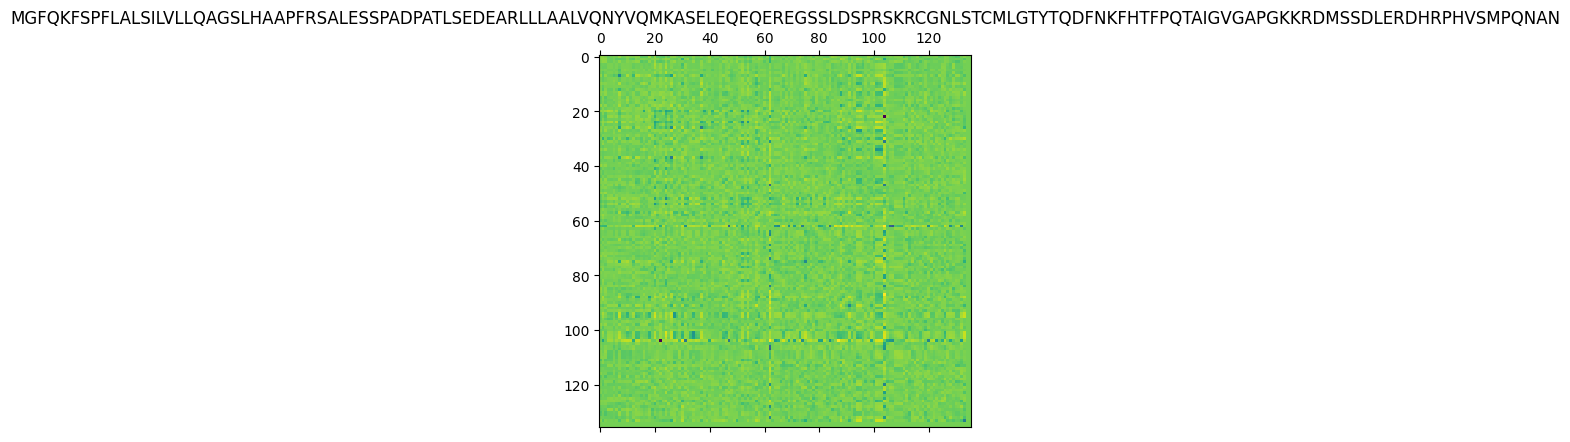

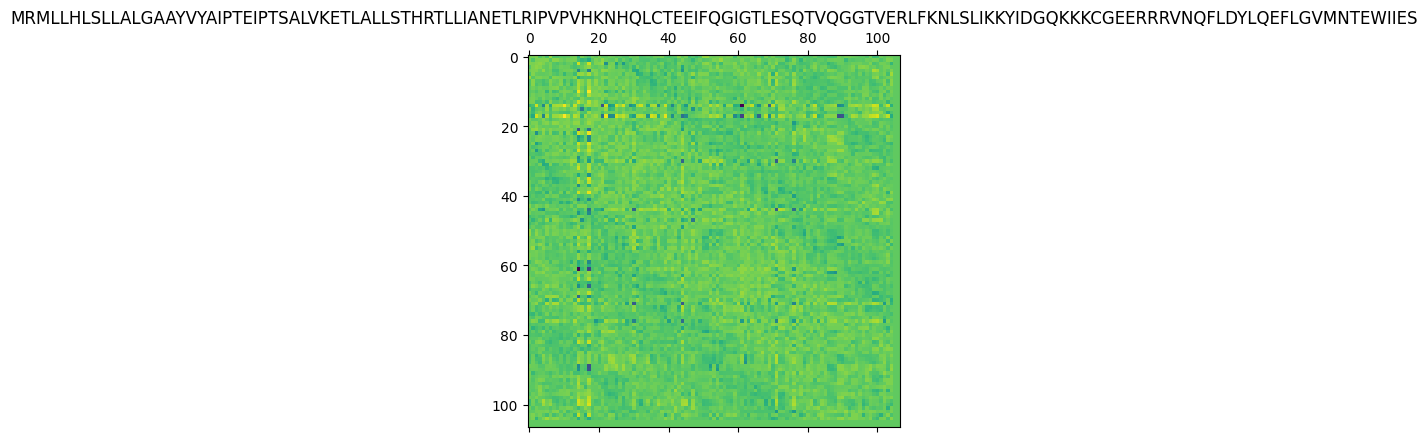

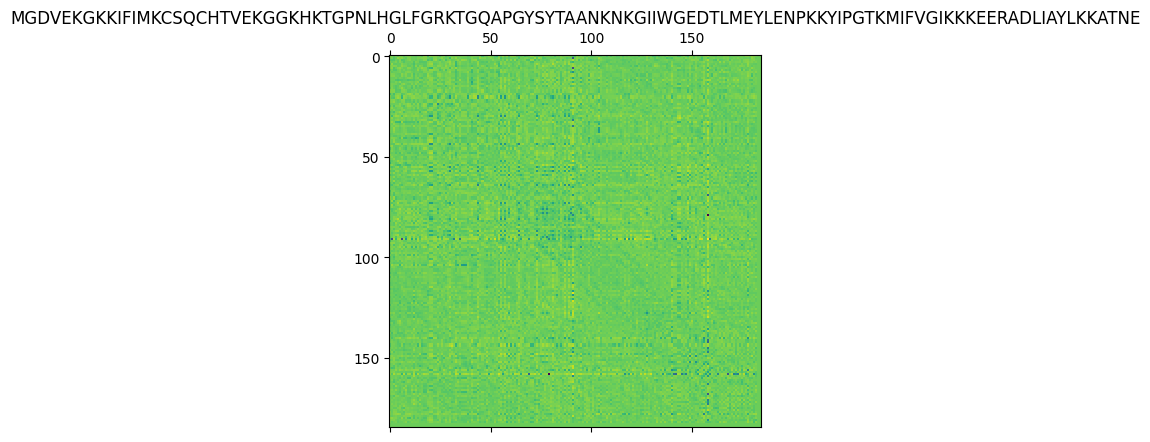

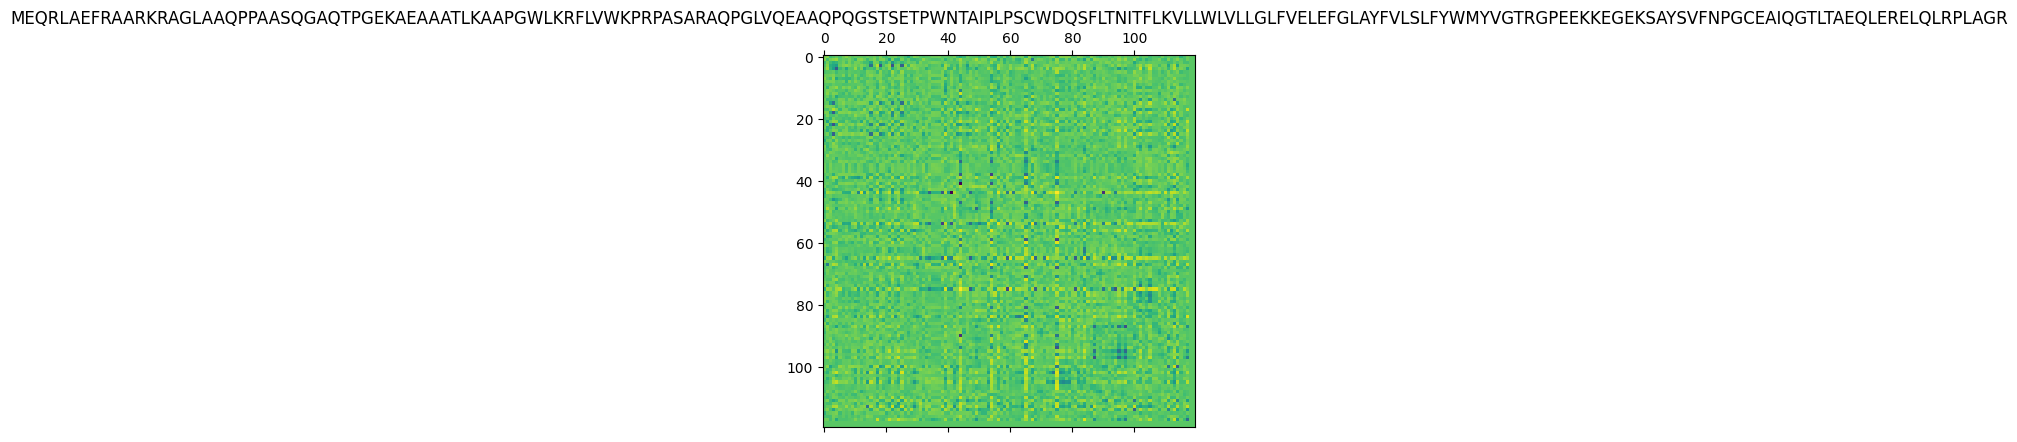

In [11]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)
model.plot(batch_tokens[1:5].to(device))

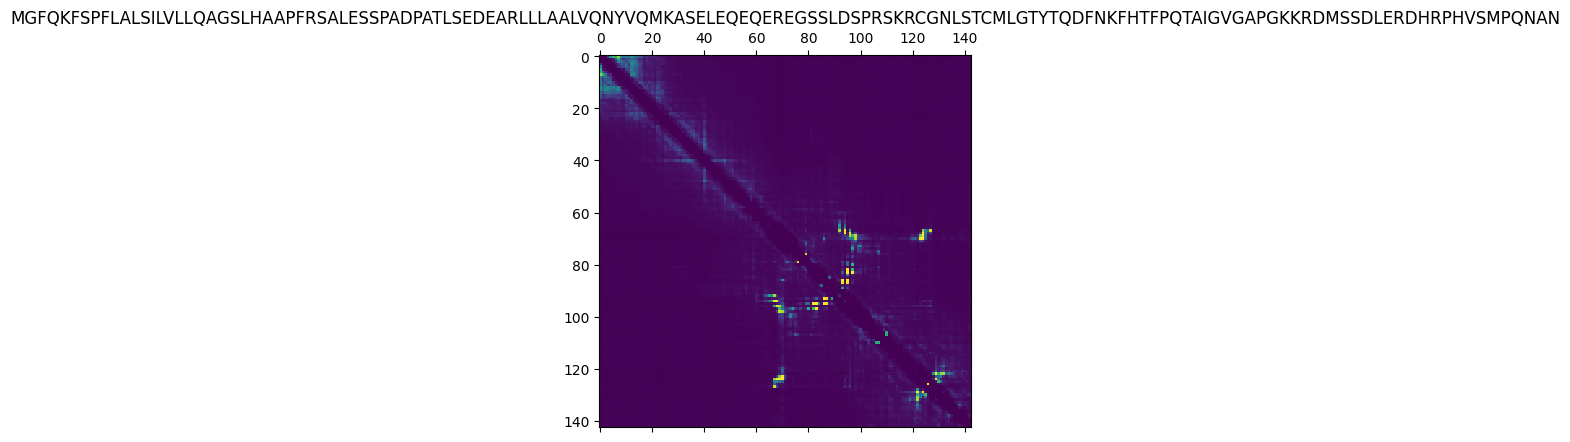

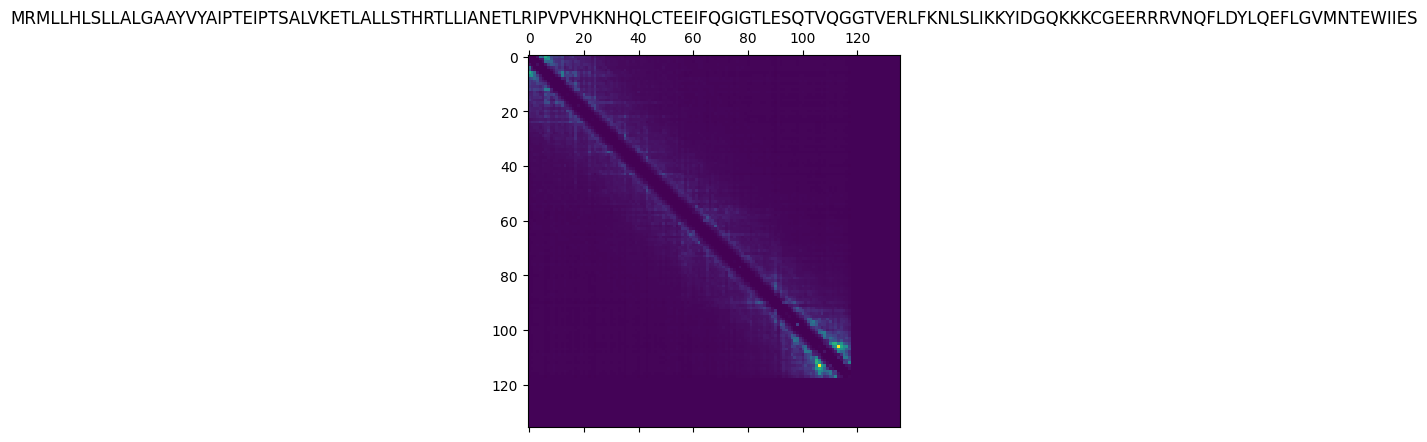

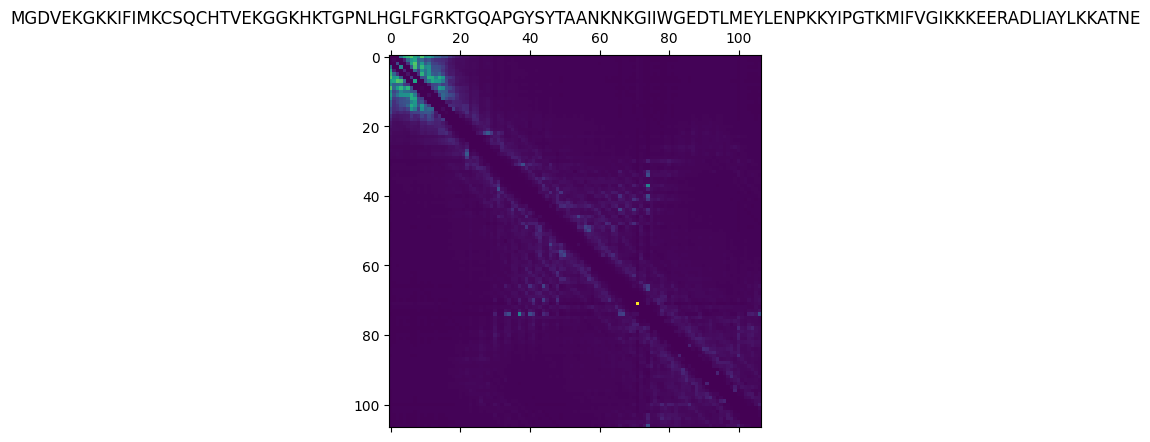

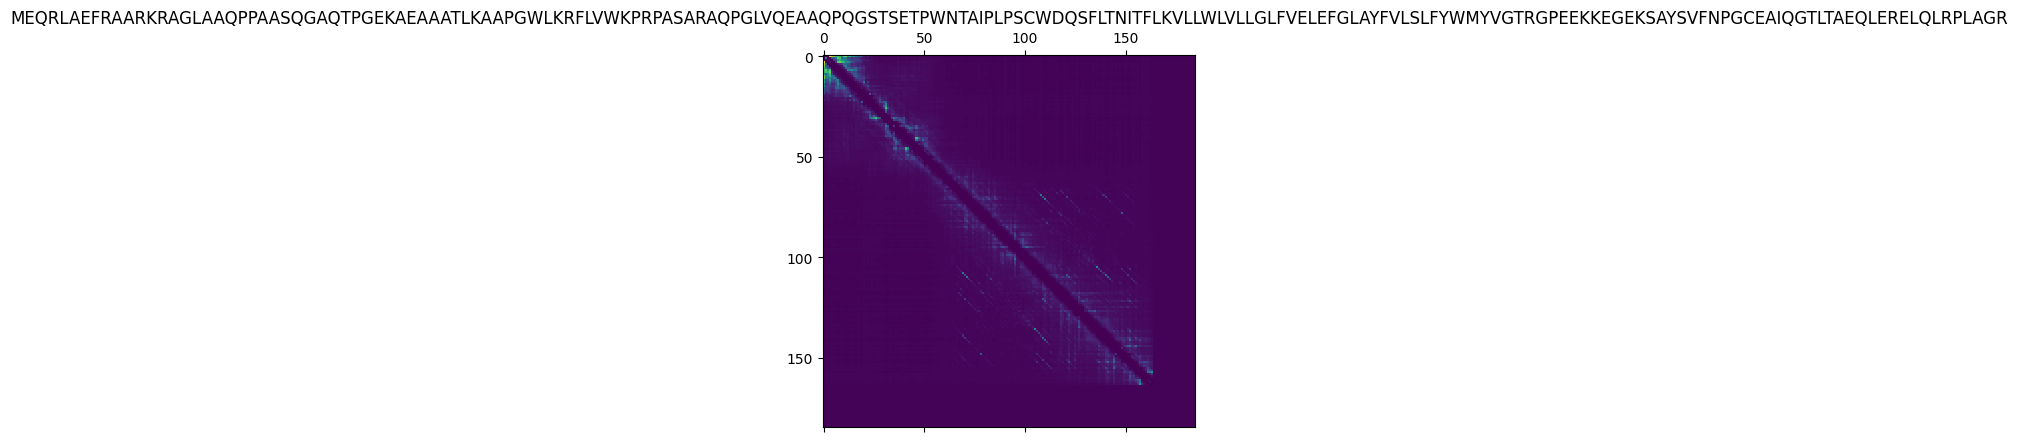

In [14]:
import torch
import esm

# Load ESM-2 model
model_esm2, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter_ = alphabet.get_batch_converter()
model_esm2.eval()  # disables dropout for deterministic results

batch_labels, batch_strs, batch_tokens = batch_converter_(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model_esm2(X_train[1:5], repr_layers=[6], return_contacts=True)
token_representations = results["representations"][6]


# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
    plt.show()

In [13]:
batch_lens

tensor([143, 136, 107, 185, 120, 144, 182, 141, 119, 171, 178, 138, 124, 118,
        197, 161, 166, 190, 149, 183, 181, 106, 186, 201, 111, 160, 137, 174,
        202, 126, 190, 166, 179, 132, 189, 126, 174, 144, 147, 167, 169, 191,
        186, 162, 182, 168, 129, 191, 126, 185, 138, 132, 128, 110, 189, 107,
        138, 128, 138, 160, 157, 136, 149, 170, 187, 165, 197, 198, 120, 134,
        184, 170, 163, 134, 192, 172, 131, 149, 157, 142, 155, 132, 155, 154,
        152, 105, 121, 118, 202, 140, 191, 143, 107, 167, 167, 103, 127, 177,
        120, 117, 179, 148, 164, 124, 163, 198, 190, 138, 120, 184, 130, 103,
        122, 103, 166, 192, 196, 157, 151, 126, 118, 148, 129, 123, 167, 145,
        186, 161, 107, 183, 106, 120, 201, 183, 123, 112, 134, 191, 162, 108,
        112, 153, 164, 144])